# Nettoyage des données
Created by: Thomas Durand-Texte, Jan. 2023

# Import des packages

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option("display.max_columns", 200)
import missingno as msno

import datetime as dt
import scipy.stats as st


import matplotlib.pyplot as plt
import seaborn as sns


import tools
cm = 1./2.54


# Reload module (for updates)

In [20]:
import importlib
cm = 1./2.54
importlib.reload(tools)
tools.set_theme( white_font=True )
# tools.plot_test_figure()

# Lectures des différentes catégories
<span style="color:red"> **Lire et compter empty cells ?** </span>
<span style="color:red"> **Autre méthode rapide ?** </span>

In [3]:
with open('openfood_OC.csv' , 'r') as file:
    categories_0 = file.readline()[:-1].split('\t')
    # print('n \\t: {:}'.format( len(line.split('\t')) ) )
    # print(line)
    # while True:
    #     line = file.readline()[:-1]
    #     if line is None: break    
    # print(file.readline())
    # print(file.readline())
print('categories:', categories_0 )

categories: ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'abbreviated_product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'packaging_en', 'packaging_text', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil',

# Définitions keys to keep/drop

In [4]:
# lst of keywords for categories that must be kept
keep_keys = '|'.join( ['nutriscore', 'labels'] )
# lst of keywords for categories that must be dropped
drop_keys = '|'.join( ['image', 'brands', 'url', 'abbreviated_product_name', 'generic_name', 'packaging'] )

categories = pd.Series( categories_0 )[~pd.Series( categories_0 ).str.contains( drop_keys ) ].to_list()
# print( categories_to_load )

# chargement des données

In [8]:
data = pd.DataFrame()

dtypes = { key:'category' for key in ['nova_group', 'nutriscore_grade'] }

for key in ['code', 'traces', 'traces_en', 'traces_tags',
            'origins_en', 'origins_tags', 'purchase_places',
            'manufacturing_places', 'manufacturing_places_tags',
            'origins', 'food_groups_tags','ingredients_from_palm_oil_tags',
            'ingredients_that_may_be_from_palm_oil_tags',
            'emb_codes_tags', 'food_groups', 'food_groups_en',
            'cities_tags', 'ecoscore_grade_fr', 'emb_codes',
            'allergens', 'additives',
            ]:
    dtypes[key]= 'object'


# data = dd.read_csv( 'openfood_OC.csv', delimiter='\t', usecols=categories, dtype=dtypes )
# data = data.compute()

if False:
    data = pd.read_csv( 'openfood_OC.csv', delimiter='\t', usecols=categories, dtype=dtypes )
    data.to_pickle( 'data0.pkl')
else:
    data = pd.read_pickle( 'data0.pkl' )
# data.head()

# dtype = { 'nova_group':'category', 'nutriscore_grade':'category', 'additives': 'object' , 'abbreviated_product_name': 'object', 'allergens': 'object', 'cities_tags': 'object', 'code': 'object', 'ecoscore_grade_fr': 'object', 'emb_codes': 'object', 'emb_codes_tags': 'object', 'first_packaging_code_geo': 'object', 'food_groups': 'object', 'food_groups_en': 'object', 'food_groups_tags': 'object', 'generic_name': 'object', 'ingredients_from_palm_oil_tags': 'object', 'ingredients_that_may_be_from_palm_oil_tags': 'object', 'manufacturing_places': 'object', 'manufacturing_places_tags': 'object', 'origins': 'object', 'origins_en': 'object', 'origins_tags': 'object', 'packaging_text': 'object', 'purchase_places': 'object', 'traces': 'object', 'traces_en': 'object', 'traces_tags': 'object'}



# data = dd.read_csv('openfood_OC.csv', delimiter ='\t', dtype=dtype)
# data = data.compute()

# # data = pd.read_csv('openfood_OC.csv', delimiter='\t', dtype=dtype)
# data.head()

# Détection des doublons
* doublons complets: <span style="color:orange"> $\rightarrow$ pas de doublon complet sur ce jeu de données </span>

1. code: <span style="color:orange">  prendre le plus récent ou le plus complet si même date </span>
2. si même date: <span style="color:orange"> prendre le plus complet </span>

In [9]:
duplicated_codes = data['code'].duplicated(keep=False)

# duplicated_full = data.loc[duplicated_codes,:].duplicated(keep=False)
# display( duplicated_full )

df_tmp = data.loc[duplicated_codes, :].copy()
df_tmp['n filled'] = len(data.keys()) - df_tmp.isnull().sum(1)

df_tmp.sort_values( by=['code', 'last_modified_datetime', 'n filled'] , inplace=True )

print('DataFrame of the duplicated rows (code)')
display( df_tmp[ ['code', 'last_modified_datetime', 'n filled'] ] )

indexes_to_drop = df_tmp.index[::2] 

if len(indexes_to_drop) > 0:
    print('indexes to rows to drop:', indexes_to_drop )
    data.drop( index= df_tmp.index[::2] , inplace=True )
else:
    print('no row to drop')

del df_tmp, indexes_to_drop

DataFrame of the duplicated rows (code)


,code,last_modified_datetime,n filled
421527,31843340000818,2021-08-17T06:35:03Z,36
349035,31843340000818,2022-02-11T08:47:36Z,38
61995,3560070278831,2021-04-17T07:44:17Z,53
188851,3560070278831,2022-02-10T18:03:06Z,59
270028,3700320230572,2021-08-24T12:58:09Z,22
749882,3700320230572,2021-08-24T12:58:58Z,39
480000,7071688002962,2021-07-13T14:26:35Z,47
477267,7071688002962,2021-07-13T14:26:35Z,52


indexes to rows to drop: Int64Index([421527, 61995, 270028, 480000], dtype='int64')


# Remove empty and some usused/unusable? columns

In [10]:
n = len(data) # number of samples
sum_isnull = data.isnull().sum() # number of null data for each column

In [11]:
n_null_lim_drop = int(0.7*n)

categories_full = sum_isnull[ sum_isnull == 0].index.to_list()
print('\nFull categories:', categories_full)

categories_hollow = sum_isnull[ sum_isnull > n_null_lim_drop].index.to_list()
print('\nHollow categories:', categories_hollow)

# drop caterories to keep (with keep_keys)
removed_cat = pd.Series( categories_hollow )
removed_cat = removed_cat[ ~removed_cat.str.contains(keep_keys) ].to_list()

# check is completely empty categories remains
removed_cat += [ key for key in sum_isnull[ sum_isnull == n].index if not key in removed_cat ]

# check for dupplicated entry and if key are still in DataFrame
removed_cat = [ key for i, key in enumerate( removed_cat ) if (not key in removed_cat[:i]) and (key in data.keys()) ]

print('\nRemoved categories:' )
if False: # vertical display
    display( pd.DataFrame( {'categorie': [key for key in removed_cat] ,
                            'n null': [sum_isnull[key] for key in removed_cat] } ) )
else: # horizontal display
    display( pd.DataFrame( { key:[np.round( sum_isnull[key]/n*100, 2)] for key in removed_cat } , index=['% isnull'] ) )

# print('')
# data.memory_usage()

if True: data.drop( columns=removed_cat, inplace=True )
# if True: data = data.drop( columns=removed_cat )

# print('')
# data.memory_usage()

# msno.bar( data )


Full categories: ['code', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'states', 'states_tags', 'states_en']

Hollow categories: ['quantity', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'cities', 'cities_tags', 'purchase_places', 'stores', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'brand_owner', 'ecoscore_score_fr', 'ecoscore_grade_fr', 'energy-kj_100g', 'energy-from-fat_100g', '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g', '-arachidic-ac

,quantity,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,emb_codes,emb_codes_tags,cities,cities_tags,purchase_places,stores,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives,additives_tags,additives_en,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,energy-kj_100g,energy-from-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,soluble-fiber_100g,insoluble-fiber_100g,casein_100g,serum-proteins_100g,nucleotides_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
% isnull,74.45,95.73,95.74,95.74,93.86,93.86,94.12,94.12,100.0,96.26,92.42,86.73,90.91,100.0,95.0,93.83,93.83,76.08,76.26,100.0,100.0,80.27,80.27,100.0,99.33,100.0,97.98,86.72,76.71,76.71,92.74,99.95,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,97.78,97.78,99.9,100.0,100.0,100.0,99.97,100.0,100.0,100.0,100.0,99.99,100.0,100.0,100.0,100.0,100.0,100.0,87.88,87.69,100.0,100.0,100.0,100.0,100.0,100.0,99.97,99.83,72.56,99.84,99.85,100.0,99.99,100.0,98.88,90.26,100.0,99.53,99.83,99.94,89.91,98.9,98.95,98.9,99.26,99.51,99.61,99.4,99.94,99.71,99.99,99.98,95.77,99.96,87.6,99.36,87.87,99.33,99.53,99.8,99.82,99.98,99.88,99.99,99.98,99.89,99.97,99.99,99.99,99.55,99.96,99.45,99.99,99.7,100.0,99.98,99.45,100.0,100.0,100.0,100.0,99.92,100.0,100.0,100.0


# Visualisation of NaN for new DataFrame

In [12]:
print(sum_isnull.size, len(categories), len(data.keys()))
with pd.option_context('display.max_rows', None):
    print( sum_isnull[data.keys()].sort_values() )

175 175 44
code                                                          0
created_t                                                     0
created_datetime                                              0
last_modified_t                                               0
last_modified_datetime                                        0
states_tags                                                   0
states                                                        0
states_en                                                     0
creator                                                       1
pnns_groups_2                                               108
pnns_groups_1                                               108
countries                                                  2300
countries_tags                                             2301
countries_en                                               2301
product_name                                              31080
energy_100g                  

<AxesSubplot: >

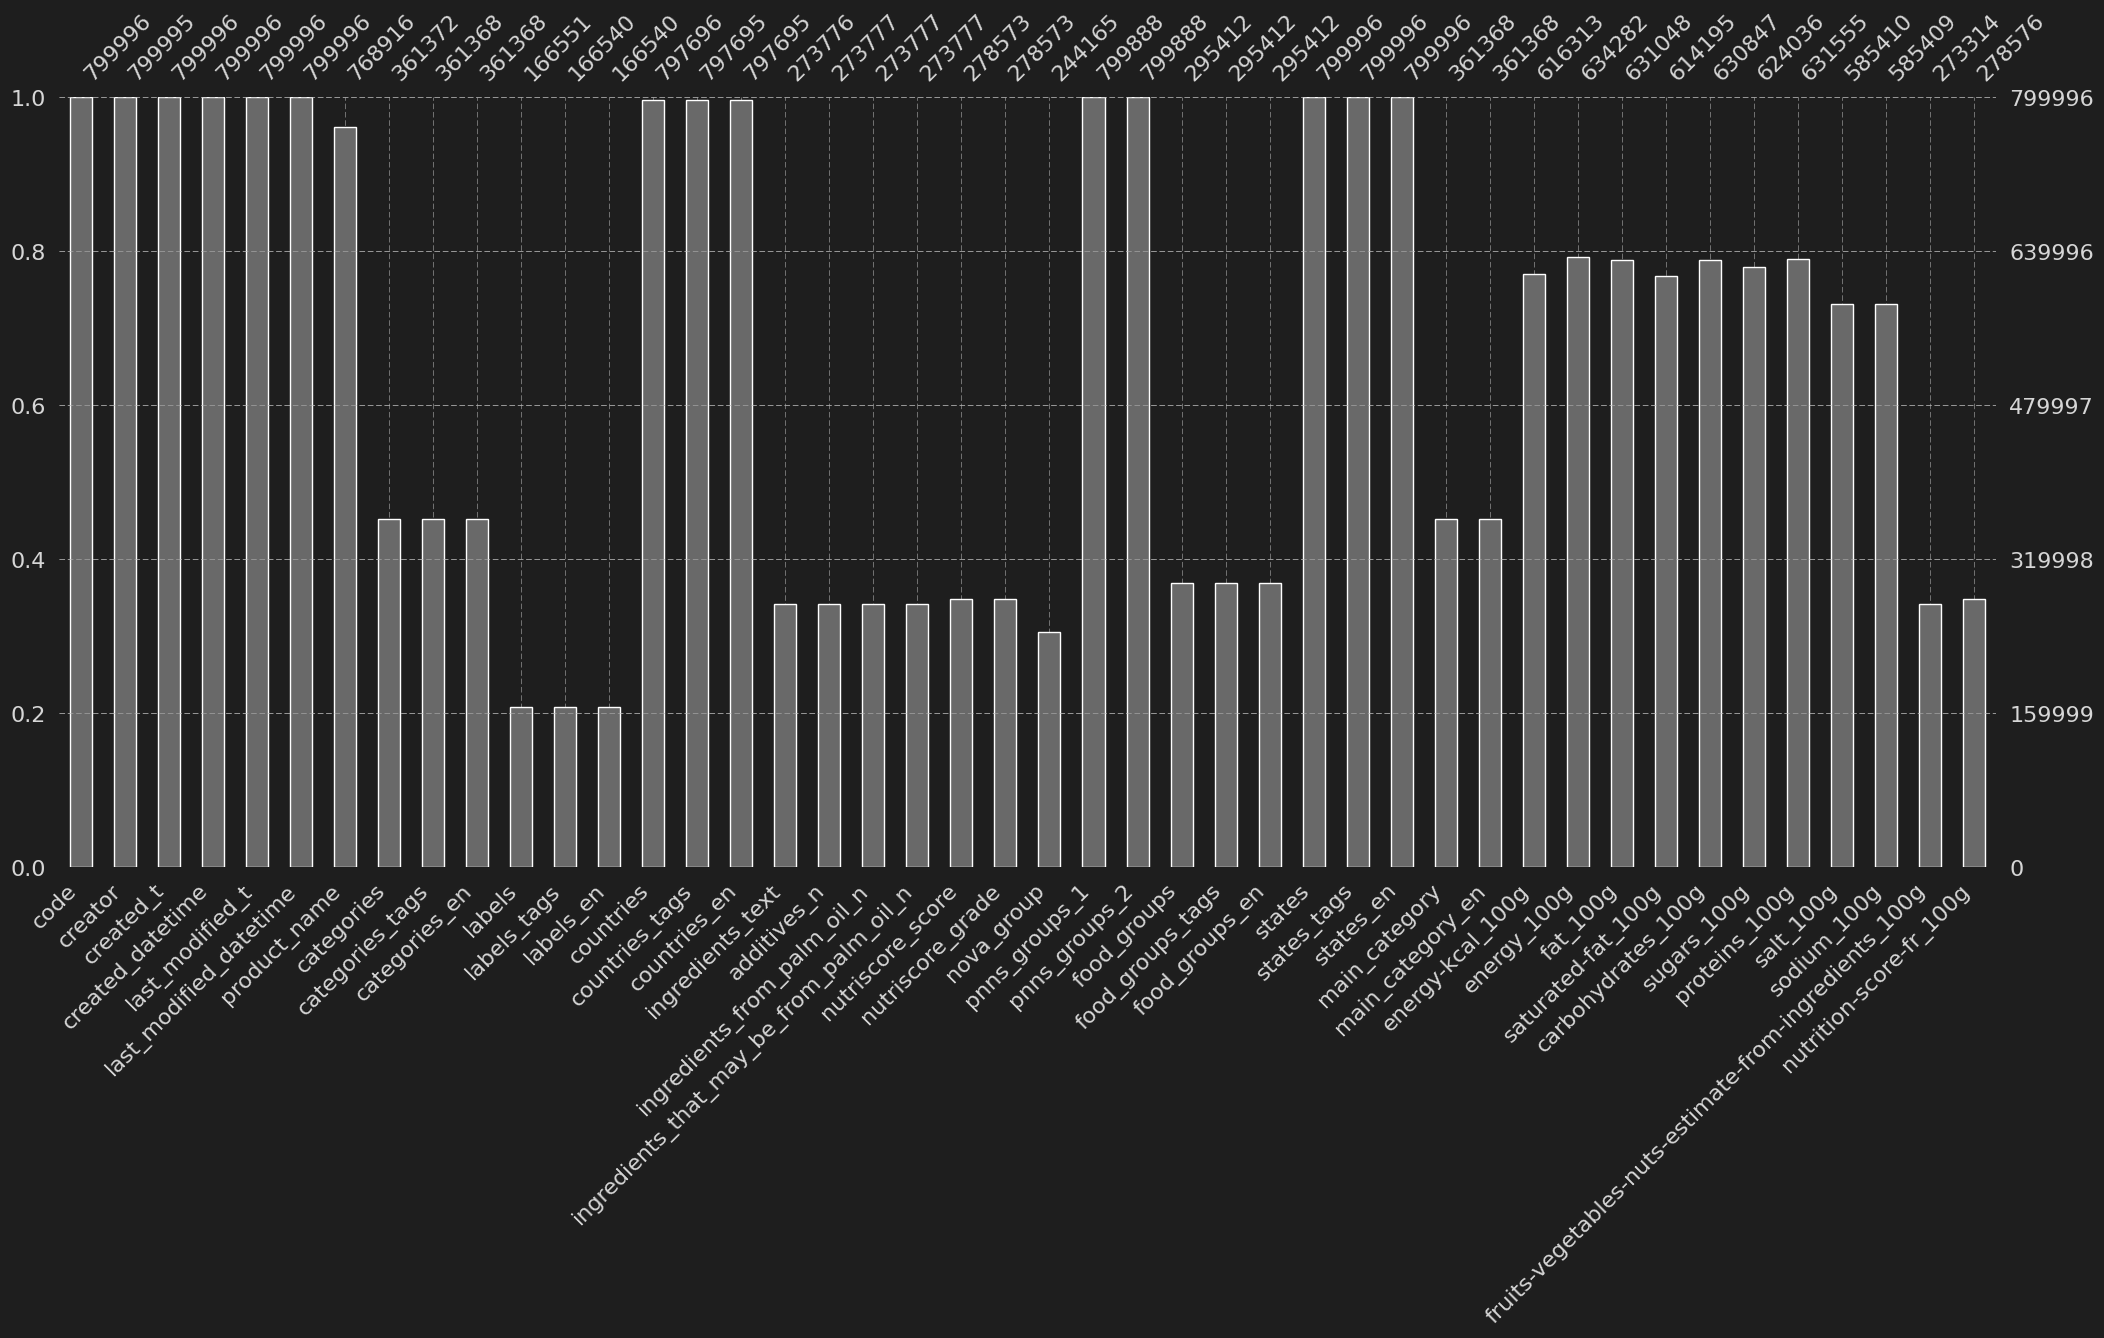

In [13]:
msno.bar( data )

# DTYPES

In [14]:
with pd.option_context('display.max_rows', None):
    display(data.dtypes)

code                                                       object
creator                                                    object
created_t                                                   int64
created_datetime                                           object
last_modified_t                                             int64
last_modified_datetime                                     object
product_name                                               object
categories                                                 object
categories_tags                                            object
categories_en                                              object
labels                                                     object
labels_tags                                                object
labels_en                                                  object
countries                                                  object
countries_tags                                             object
countries_

# Listes des catégories: string / float64 / others

In [15]:
categories_float, categories_others = [], []
for cat in data.keys():
    if data.dtypes[cat] == 'float64': categories_float.append( cat )
    else: categories_others.append( cat )
# ax = msno.heatmap( data[ [key for key in data.keys() if (not key in categories_full) and (not '_100g' in key) or 'score' in key] ] )
categories_string = []
# print('\nstrings to lowercase')
for key in categories_others: 
    # print(key, 'type', data[key].dtype)
    if data[key].dtype != 'object': continue
    categories_string.append( key )
    # data[key].str.lower()

categories_others = [key for key in categories_others if not key in categories_string]
print("float categories:", categories_float )
print("\nstring categories:", categories_string )
print("\nothers categories:", categories_others )


float categories: ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score', 'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'nutrition-score-fr_100g']

string categories: ['code', 'creator', 'created_datetime', 'last_modified_datetime', 'product_name', 'categories', 'categories_tags', 'categories_en', 'labels', 'labels_tags', 'labels_en', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'pnns_groups_1', 'pnns_groups_2', 'food_groups', 'food_groups_tags', 'food_groups_en', 'states', 'states_tags', 'states_en', 'main_category', 'main_category_en']

others categories: ['created_t', 'last_modified_t', 'nutriscore_grade', 'nova_group']


# Analyse variables category
1. rename_categories 
    - nitriscore_grade $\rightarrow$ upper
    - nova_group $\rightarrow$ int
1. str.lower
1. replace <span style="color:orange"> unknown </span> $\rightarrow$ <span style="color:orange"> NaN </span> in 'pnn_groups'
1. food_groups: <span style="color:orange"> 'en:' </span> $\rightarrow$ <span style="color:orange"> '' </span>, <span style="color:orange"> '-' </span> $\rightarrow$ <span style="color:orange"> ' ' </span> (for readability)
1. print first values for each category

In [17]:
string_catergories_to_value_count = ['nova_group', 'nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2', 'food_groups']

# Modification of categories (nitriscore_grade -> upper, nova_group -> int)
data['nutriscore_grade'] = data['nutriscore_grade'].cat.rename_categories( {cat:cat.upper() for cat in data['nutriscore_grade'].cat.categories} )
data['nova_group'] = data['nova_group'].cat.rename_categories( {cat:int(float(cat)) for cat in data['nova_group'].cat.categories} )

# lower all string
for key in string_catergories_to_value_count:
    print('\n', key, data[key].dtype.kind)
    # if data[key].dtype.kind != 'O': continue # Check if dtyp is object
    # if not pd.api.types.is_string_dtype( data[key].dtype ): continue
    if data[key].dtype != 'object': continue
    data[key] = data[key].str.lower()

# replace 'unknown' to NaN
data.replace( {'pnns_groups_1':'unknown', 'pnns_groups_2':'unknown'}, np.nan, inplace=True )
data.replace( { 'pnns_groups_1':{'unknown':np.nan},
                'pnns_groups_2':{'unknown':np.nan} }, inplace=True )

# replace "en:" and "-" in food_groups to improve readability
data['food_groups'] = data['food_groups'].str.replace( 'en:' , '' , regex=False )
data['food_groups'] = data['food_groups'].str.replace( '-', ' ' , regex=False )

# astype category
# data[string_catergories_to_value_count] = data[string_catergories_to_value_count].astype('category')

for key in string_catergories_to_value_count:
    print('\n', key, data.dtypes[key])
    i = 0
    for value in data[key] :
        if pd.isnull( value ) : continue
        print(value )
        i += 1
        if i == 10: break

dico_value_counts = { key: data[key].value_counts().sort_values() for key in string_catergories_to_value_count }


 nova_group O

 nutriscore_grade O

 pnns_groups_1 O

 pnns_groups_2 O

 food_groups O

 nova_group category
3
4
3
3
3
4
4
1
1
4

 nutriscore_grade category
D
E
D
A
D
B
B
B
A
D

 pnns_groups_1 object
beverages
milk and dairy products
beverages
fish meat eggs
fish meat eggs
milk and dairy products
fat and sauces
beverages
fish meat eggs
fish meat eggs

 pnns_groups_2 object
teas and herbal teas and coffees
dairy desserts
waters and flavored waters
fish and seafood
meat
cheese
dressings and sauces
fruit juices
meat
meat

 food_groups object
teas and herbal teas and coffees
dairy desserts
waters and flavored waters
fish and seafood
poultry
cheese
dressings and sauces
unsweetened beverages
poultry
poultry


,nova_group,nutriscore_grade,pnns_groups_1,pnns_groups_2,food_groups
0,4,5,10,40,46


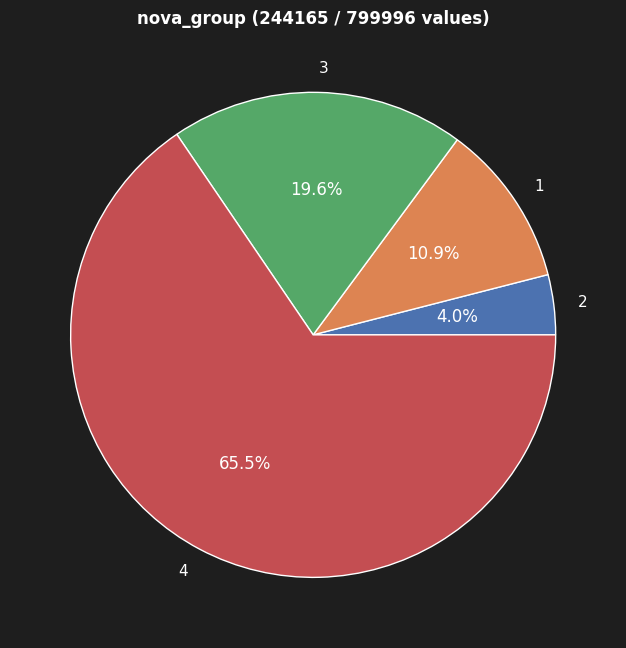

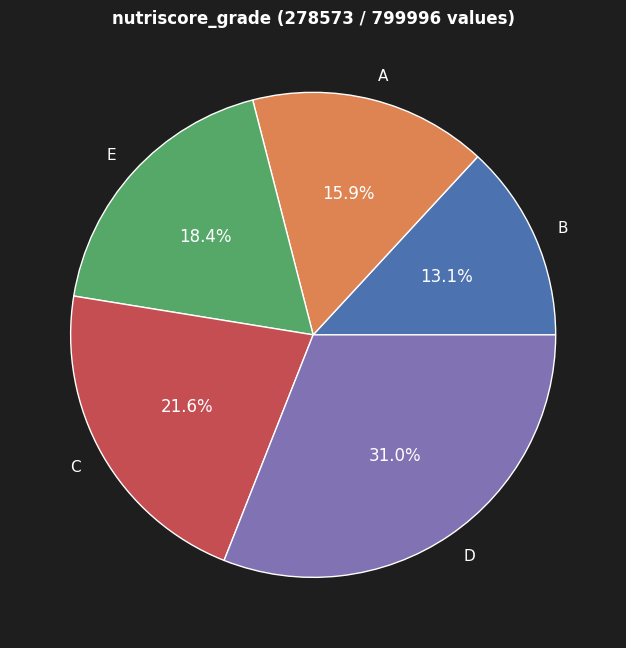

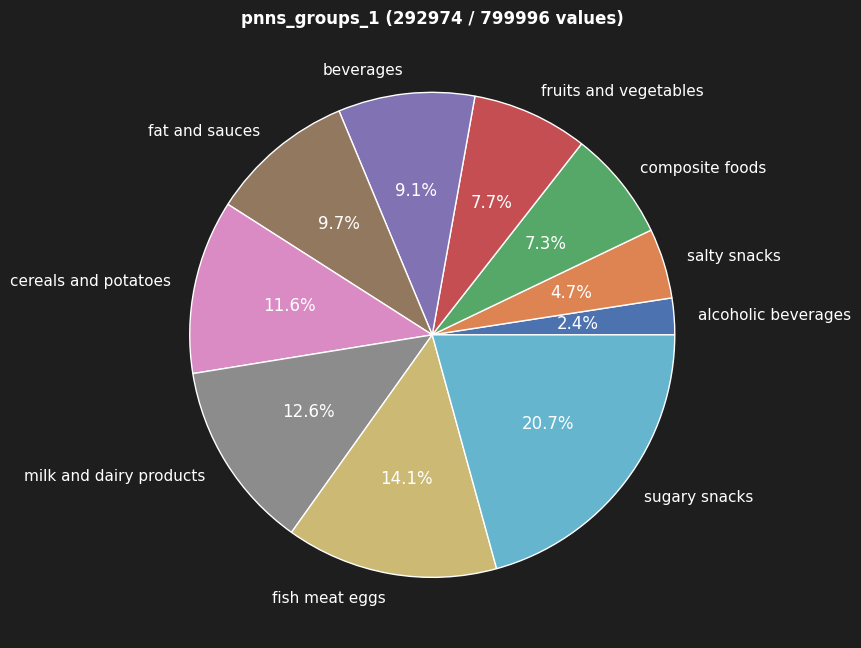

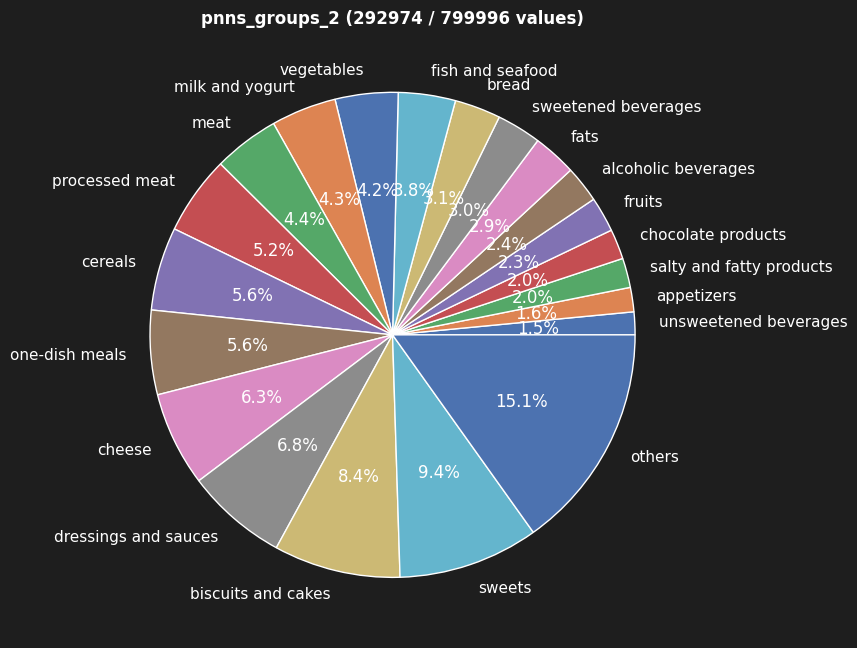

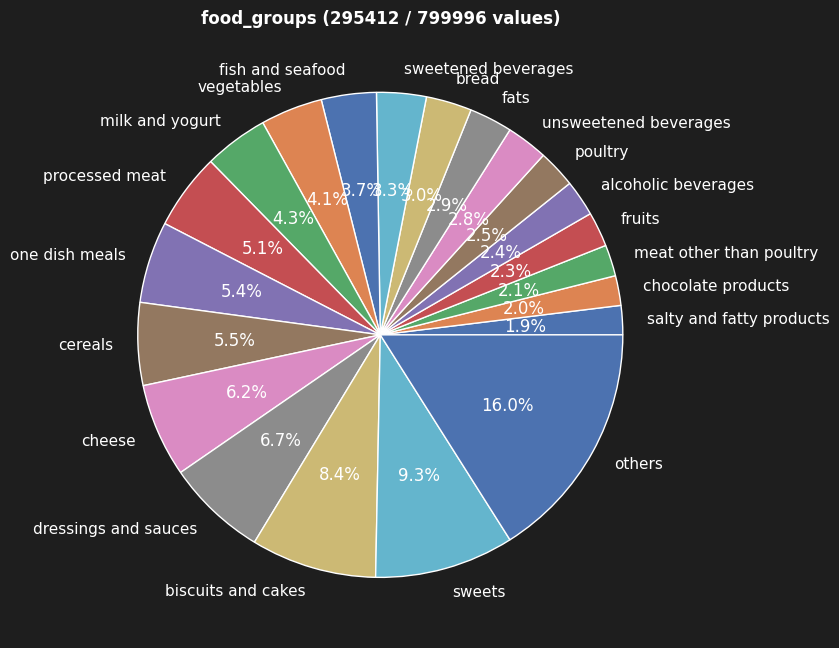

In [18]:
data_value_counts = pd.DataFrame( {key:[len(dico_value_counts[key])] for key in string_catergories_to_value_count} )
display(data_value_counts)
# data_value_counts.plot( kind='bar' )

# print('min counts', data_value_counts.iloc[0,:].min() )

n_lim_categories = 20
for key in string_catergories_to_value_count:
    sr_plot = dico_value_counts[key]
    n_sum = sr_plot.sum()

    if dico_value_counts[key].size > n_lim_categories:
        sr_plot = sr_plot.sort_values( ascending=False )
        sr_plot = pd.concat( [sr_plot[:n_lim_categories], 
                                pd.Series( [sr_plot[n_lim_categories:].sum()] , index=['others'] ),
                             ] )
        

    fig, ax = plt.subplots( figsize=(20*cm,20*cm))
    # pd.Series( sr_plot.sort_index( ascending=True ) ).plot( kind='pie' , ax=ax, autopct='%.1f%%' )
    pd.Series( sr_plot.sort_values( ascending=True ) ).plot( kind='pie' , ax=ax, autopct='%.1f%%' )
    ax.set_title( '{:} ({:} / {:} values)'.format( key, n_sum, n), weight='bold')
    ax.set_ylabel('')

    # fig, ax = plt.subplots( figsize=(20*cm, 10*cm*(data_value_counts[key][0]/10)) )
    # pd.Series( dico_value_counts[key] ).plot( kind='barh' , ax=ax )
    # ax.set_title(key)

if False: # barplot
    cat_pos = np.arange( len(string_catergories_to_value_count) )
    print(cat_pos)
    fig, ax = plt.subplots( figsize=(20*cm,10*cm))
    if True: # horizontal
        ax.bar( cat_pos, data_value_counts.iloc[0,:] , align='center')
        ax.set_xticks(cat_pos, labels=string_catergories_to_value_count)
    else:
        ax.barh( cat_pos, data_value_counts.iloc[0,:] , align='center')
        ax.set_yticks(cat_pos, labels=string_catergories_to_value_count)
        ax.invert_yaxis()  # labels read top-to-bottom

    fig.tight_layout()
    del cat_pos


# Comparaison pnns_groups_1/_2 et food_groups: tableaux de contingences
<span style="color:red"> (+ seuil ? $\rightarrow$ $\chi^2$) </span>

nan in data_chi:
pnns_groups_1    0
pnns_groups_2    0
food_groups      0
dtype: int64


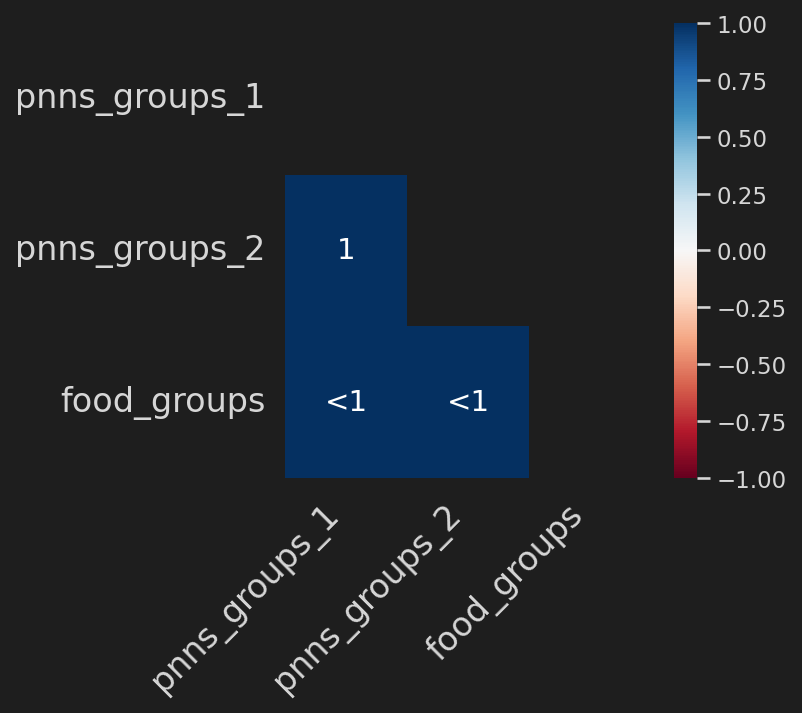

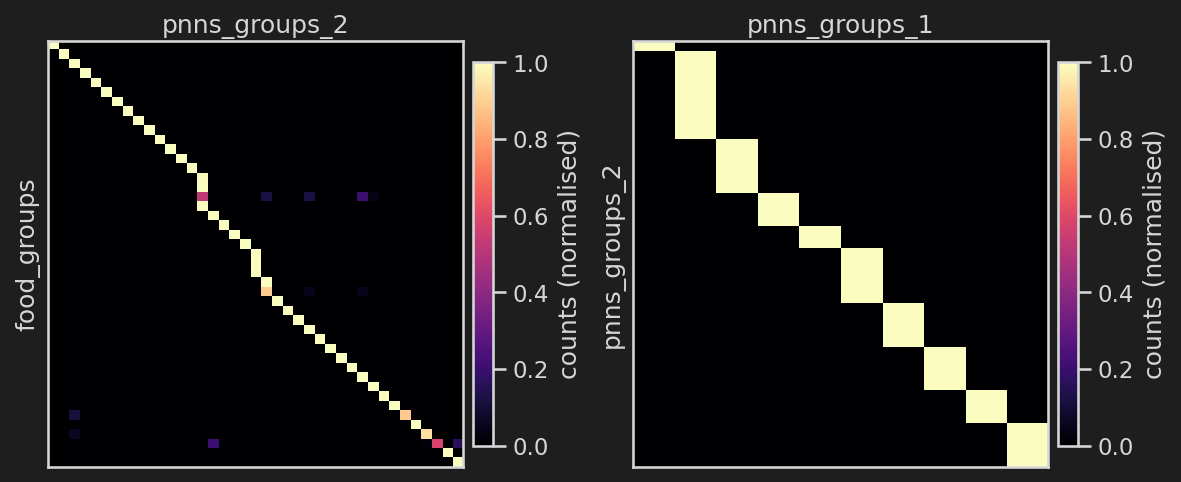

In [24]:
data_chi = data[['pnns_groups_1', 'pnns_groups_2', 'food_groups']].copy()

fig, ax = plt.subplots( figsize=(10*cm,10*cm))
msno.heatmap( data_chi , ax=ax )

# drop all rows with at least one NaN
data_chi.drop( data_chi.index[ data_chi.isnull().sum(1) > 0 ] , inplace=True )

# check drop
print('nan in data_chi:')
print( data_chi.isnull().sum() )

type_plot = ['xi', 'count'][1]

X2, Y2 = 'pnns_groups_2', 'pnns_groups_1'
X1, Y1 = 'food_groups', 'pnns_groups_2'

fig, axs = plt.subplots( 1,2, figsize= (20*cm, 8*cm) )
for i, (X,Y) in enumerate( [ (X1,Y1), (X2,Y2) ] ):
    xi_ij, contingences = tools.chi2( data_chi, X, Y )

    image = contingences.values
    image = image[:-1,:-1] / image[:-1,-1:]
    argsort_rows = image.argmax(1).argsort()
    # display( contingences.iloc[argsort_rows,:] )
    if type_plot == 'xi':
        image = xi_ij.values[:-1,:-1]
        label = r'$\xi_{ij} \, / \, \xi_{n}$'
    else:
        label = r'counts (normalised)'
    image = image[ argsort_rows ]

    # figsize = tools.image_size_from_height_and_shape( 12*cm, image.shape, xmargin=1*cm)
    # print( 'figsize', figsize)
    # fig, ax = plt.subplots( figsize=figsize )
    im = axs[i].imshow( image , cmap='magma', aspect='auto' )
    # axs[i].axis('off')
    # cb = plt.colorbar( im, ax=ax, orientation='horizontal', pad=0.01, label=r'$\xi_{ij} \, / \, \xi_{n}$')
    cb = plt.colorbar( im, ax=axs[i], pad=0.02, shrink=[0.9, 0.9][i], label=label)

axs[0].set_xlabel(Y1)
axs[0].set_ylabel(X1)

axs[1].set_xlabel(Y2)
axs[1].set_ylabel(X2)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 


fig.tight_layout( pad=0.4 )
plt.show()
del image, cb, im, axs, fig
del X1,Y1, X2,Y2

# Analyse variables float
<span style="color:red"> **À gérer/différencier:** </span>
* all : values < 0
* energy kcal : limite 900 kcal / <span style="color:yellow">  (**conaissance métier**) </span>
* salt / sodium:  <= 100
* others : <= 100 ?
* calcul sum quantity ( w/o trans- saturated-fats) : <=100
* <span style="color:yellow"> saturated-fats > fats -> saturated-fats = nan (IDEM SODIUM/SEL , sugar/carbohydrates) </span>

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
count,273779.000000,273779.000000,273779.000000,278575.000000,6.163160e+05,6.342850e+05,6.310520e+05,6.141980e+05,6.308510e+05,6.240400e+05,6.315590e+05,5.854130e+05,5.854120e+05,273316.000000,278578.000000
mean,2.019019,0.019750,0.069965,9.121296,1.765230e+08,1.050878e+37,1.744705e+08,1.627096e+05,1.584378e+05,1.604063e+08,1.582406e+05,1.707070e+05,6.828290e+04,8.572664,9.121391
std,2.884767,0.140938,0.303732,8.848561,1.278597e+11,8.369400e+39,1.384715e+11,1.275127e+08,1.258185e+08,1.265884e+11,1.257479e+08,1.306100e+08,5.224406e+07,36.811276,8.848580
min,0.000000,0.000000,0.000000,-15.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-5.000000e+02,0.000000e+00,0.000000e+00,0.000000,-15.000000
25%,0.000000,0.000000,0.000000,1.000000,1.010000e+02,4.180000e+02,8.000000e-01,1.000000e-01,3.521127e+00,6.000000e-01,1.330000e+00,8.250000e-02,3.300000e-02,0.000000,1.000000
50%,1.000000,0.000000,0.000000,10.000000,2.600000e+02,1.080000e+03,7.000000e+00,1.800000e+00,1.540000e+01,3.570000e+00,6.000000e+00,5.875000e-01,2.350000e-01,0.000000,10.000000
75%,3.000000,0.000000,0.000000,16.000000,4.000000e+02,1.674000e+03,2.130000e+01,7.100000e+00,5.300000e+01,1.750000e+01,1.250000e+01,1.400000e+00,5.600000e-01,0.500000,16.000000
max,49.000000,3.000000,5.000000,40.000000,1.000000e+14,6.665559e+42,1.100000e+14,9.993273e+10,9.993273e+10,1.000000e+14,9.993273e+10,9.993273e+10,3.997309e+10,13461.000000,40.000000
IQ,3.000000,0.000000,0.000000,15.000000,2.990000e+02,1.256000e+03,2.050000e+01,7.000000e+00,4.947887e+01,1.690000e+01,1.117000e+01,1.317500e+00,5.270000e-01,0.500000,15.000000


,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
count,273779.000000,273779.000000,273779.000000,278575.000000,6.163160e+05,627378.00000,6.310520e+05,6.141980e+05,6.308510e+05,6.240400e+05,6.315590e+05,5.854130e+05,5.854120e+05,273316.000000,278578.000000
mean,2.019019,0.019750,0.069965,9.121296,1.765230e+08,1109.93770,1.744705e+08,1.627096e+05,1.584378e+05,1.604063e+08,1.582406e+05,1.707070e+05,6.828290e+04,8.572664,9.121391
std,2.884767,0.140938,0.303732,8.848561,1.278597e+11,770.15859,1.384715e+11,1.275127e+08,1.258185e+08,1.265884e+11,1.257479e+08,1.306100e+08,5.224406e+07,36.811276,8.848580
min,0.000000,0.000000,0.000000,-15.000000,0.000000e+00,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-5.000000e+02,0.000000e+00,0.000000e+00,0.000000,-15.000000
25%,0.000000,0.000000,0.000000,1.000000,1.010000e+02,418.00000,8.000000e-01,1.000000e-01,3.521127e+00,6.000000e-01,1.330000e+00,8.250000e-02,3.300000e-02,0.000000,1.000000
50%,1.000000,0.000000,0.000000,10.000000,2.600000e+02,1067.00000,7.000000e+00,1.800000e+00,1.540000e+01,3.570000e+00,6.000000e+00,5.875000e-01,2.350000e-01,0.000000,10.000000
75%,3.000000,0.000000,0.000000,16.000000,4.000000e+02,1661.00000,2.130000e+01,7.100000e+00,5.300000e+01,1.750000e+01,1.250000e+01,1.400000e+00,5.600000e-01,0.500000,16.000000
max,49.000000,3.000000,5.000000,40.000000,1.000000e+14,3556.00000,1.100000e+14,9.993273e+10,9.993273e+10,1.000000e+14,9.993273e+10,9.993273e+10,3.997309e+10,13461.000000,40.000000


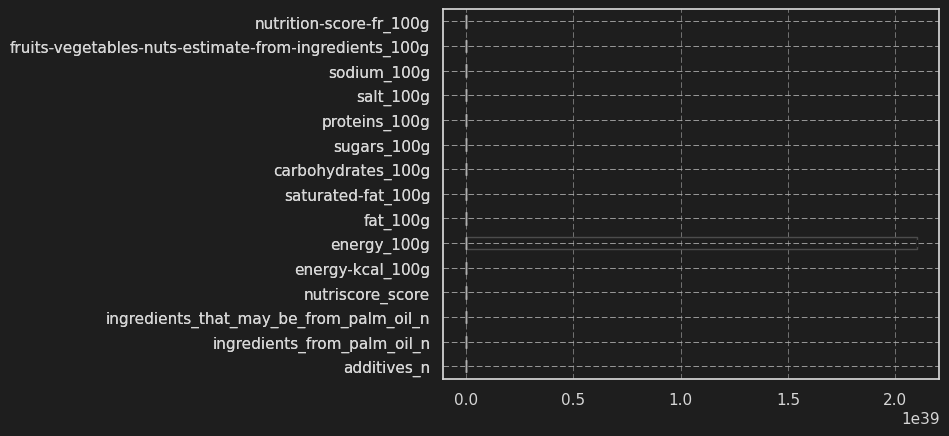

In [22]:
df_describe = data[categories_float].describe()
df_describe.boxplot( showfliers=False, vert=False )

IQs = df_describe.loc['75%', :] - df_describe.loc['25%', :]


# display(IQs)
df_describe = pd.concat( (df_describe, IQs.to_frame().T) , ignore_index=False )
df_describe.rename( index={0:'IQ'}, inplace=True )
display( df_describe )

key = 'energy_100g'
data.loc[ data[key] > df_describe[key]['75%'] + 1.5*df_describe[key]['IQ'] , key ] = np.nan

df_describe = data[categories_float].describe()
df_describe.boxplot( showfliers=False, vert=False )
display( df_describe )


# Labels
Several labels per product

In [ ]:
key = 'labels_en'

print('Example of labels:\n')
i = 0
for value in data[key]:
        if value is np.nan : continue
        print(value)
        i += 1
        if i == 10: break
dico_value_labels = tools.value_count_labels_in_string_series( data.loc[~data[key].isnull(),key] , ',' )
print(dico_value_labels)

# Visiualisation of NaN with missingno
as barplot 

In [ ]:
msno.bar( data )

# Heatmap without fully filled categories

In [ ]:
msno.heatmap( data[ [key for key in data.keys() if (not key in categories_full)] ] )

# Heatmap without fully filled categories (qualitatives + nutriscore)

In [ ]:
ax = msno.heatmap( data[ [key for key in data.keys() if (not key in categories_full) and (not '_100g' in key) or 'score' in key] ] )

# A REGARDER

df = pd.DataFrame({"value": np.random.randint(0, 100, 20)})

labels = ["{0} - {1}".format(i, i + 9) for i in range(0, 100, 10)]

df["group"] = pd.cut(df.value, range(0, 105, 10), right=False, labels=labels)

df.head(10)
Out[9]: 
   value    group
0     65  60 - 69
1     49  40 - 49
2     56  50 - 59
3     43  40 - 49
4     43  40 - 49
5     91  90 - 99
6     32  30 - 39
7     87  80 - 89
8     36  30 - 39
9      8    0 - 9



s.str.contains('foo|bar', na=False, regex=False)
# na to manage nan (to False)
# regex=False to speed up, when regex-based search is not needed

# `axis=1` tells `apply` to apply the lambda function column-wise.
df.apply(lambda col: col.str.contains('foo|bar', na=False), axis=1)

terms = ['foo', 'baz']
df4[df4['col'].str.contains('|'.join(terms))]

How do I select by partial string from a pandas DataFrame?
This post is meant for readers who want to

search for a substring in a string column (the simplest case) as in df1[df1['col'].str.contains(r'foo(?!$)')]
search for multiple substrings (similar to isin), e.g., with df4[df4['col'].str.contains(r'foo|baz')]
match a whole word from text (e.g., "blue" should match "the sky is blue" but not "bluejay"), e.g., with df3[df3['col'].str.contains(r'\bblue\b')]
match multiple whole words
Understand the reason behind "ValueError: cannot index with vector containing NA / NaN values" and correct it with str.contains('pattern',na=False)
...and would like to know more about what methods should be preferred over others.

(P.S.: I've seen a lot of questions on similar topics, I thought it would be good to leave this here.)

Friendly disclaimer, this is post is long.

Basic Substring Search
# setup
df1 = pd.DataFrame({'col': ['foo', 'foobar', 'bar', 'baz']})
df1

      col
0     foo
1  foobar
2     bar
3     baz
str.contains can be used to perform either substring searches or regex based search. The search defaults to regex-based unless you explicitly disable it.

Here is an example of regex-based search,

# find rows in `df1` which contain "foo" followed by something
df1[df1['col'].str.contains(r'foo(?!$)')]

      col
1  foobar
Sometimes regex search is not required, so specify regex=False to disable it.

#select all rows containing "foo"
df1[df1['col'].str.contains('foo', regex=False)]
# same as df1[df1['col'].str.contains('foo')] but faster.
   
      col
0     foo
1  foobar
Performance wise, regex search is slower than substring search:

df2 = pd.concat([df1] * 1000, ignore_index=True)

%timeit df2[df2['col'].str.contains('foo')]
%timeit df2[df2['col'].str.contains('foo', regex=False)]

6.31 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.8 ms ± 241 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Avoid using regex-based search if you don't need it.

Addressing ValueErrors
Sometimes, performing a substring search and filtering on the result will result in

ValueError: cannot index with vector containing NA / NaN values
This is usually because of mixed data or NaNs in your object column,

s = pd.Series(['foo', 'foobar', np.nan, 'bar', 'baz', 123])
s.str.contains('foo|bar')

0     True
1     True
2      NaN
3     True
4    False
5      NaN
dtype: object


s[s.str.contains('foo|bar')]
# ---------------------------------------------------------------------------
# ValueError                                Traceback (most recent call last)
Anything that is not a string cannot have string methods applied on it, so the result is NaN (naturally). In this case, specify na=False to ignore non-string data,

s.str.contains('foo|bar', na=False)

0     True
1     True
2    False
3     True
4    False
5    False
dtype: bool
How do I apply this to multiple columns at once?
The answer is in the question. Use DataFrame.apply:

# `axis=1` tells `apply` to apply the lambda function column-wise.
df.apply(lambda col: col.str.contains('foo|bar', na=False), axis=1)

       A      B
0   True   True
1   True  False
2  False   True
3   True  False
4  False  False
5  False  False
All of the solutions below can be "applied" to multiple columns using the column-wise apply method (which is OK in my book, as long as you don't have too many columns).

If you have a DataFrame with mixed columns and want to select only the object/string columns, take a look at select_dtypes.

Multiple Substring Search
This is most easily achieved through a regex search using the regex OR pipe.

# Slightly modified example.
df4 = pd.DataFrame({'col': ['foo abc', 'foobar xyz', 'bar32', 'baz 45']})
df4

          col
0     foo abc
1  foobar xyz
2       bar32
3      baz 45

df4[df4['col'].str.contains(r'foo|baz')]

          col
0     foo abc
1  foobar xyz
3      baz 45
You can also create a list of terms, then join them:

terms = ['foo', 'baz']
df4[df4['col'].str.contains('|'.join(terms))]

          col
0     foo abc
1  foobar xyz
3      baz 45
Sometimes, it is wise to escape your terms in case they have characters that can be interpreted as regex metacharacters. If your terms contain any of the following characters...

. ^ $ * + ? { } [ ] \ | ( )
Then, you'll need to use re.escape to escape them:

import re
df4[df4['col'].str.contains('|'.join(map(re.escape, terms)))]

          col
0     foo abc
1  foobar xyz
3      baz 45
re.escape has the effect of escaping the special characters so they're treated literally.

re.escape(r'.foo^')
# '\\.foo\\^'


# END OF NOTEBOOK

In [ ]:
fig = ax.get_figure()
fig.tight_layout()
tools.savefig( fig, 'Figures/test' )